In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.stats import beta
from tqdm.notebook import tqdm
import seaborn as sns

#load the jason file
file_path = r"C:\Users\sajad\Downloads\2armed_bandit.json"
with open(file_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head(204)






rt                                           stimulus response  \
0    6946.0  <div style='color:white'>Welcome to our decisi...            
1    1287.0  <div style='color:white'>\n    <div class="slo...            
2    1130.0  <div style='color:white'>After selecting a ban...            
3     520.0  <div style='color:white'>Your goal is to earn ...            
4    1414.0  [<div class="slotmachine" style="position: abs...        0   
..      ...                                                ...      ...   
199     NaN           <div style='color:white'>Score: 63</div>     None   
200  1108.0  [<div class="slotmachine" style="position: abs...        0   
201     NaN           <div style='color:white'>Score: 63</div>     None   
202   610.0  [<div class="slotmachine" style="position: abs...        0   
203     NaN           <div style='color:white'>Score: 64</div>     None   

                 trial_type  trial_index  time_elapsed internal_node_id  \
0    html-keyboard-response            0          6951      0.0-0.0-0.0   
1    html-keyboard-response            1          8241      0.0-0.0-1.0   
2    html-keyboard-response            2          9372      0.0-0.0-2.0   
3    html-keyboard-response            3          9894      0.0-0.0-3.0   
4               html-choice            4         13317      0.0-1.0-0.0   
..                      ...          ...           ...              ...   
199  html-keyboard-response          199        374656     0.0-1.0-1.97   
200             html-choice          200        377776     0.0-1.0-0.98   
201  html-keyboard-response          201        378780     0.0-1.0-1.98   
202             html-choice          202        381398     0.0-1.0-0.99   
203  html-keyboard-response          203        382400     0.0-1.0-1.99   

     bean_trial_duration  bean_duration  \
0                    NaN            NaN   
1                    NaN            NaN   
2                    NaN            NaN   
3                    NaN            NaN   
4                    NaN            NaN   
..                   ...            ...   
199               1000.0         1000.0   
200                  NaN            NaN   
201               1000.0         1000.0   
202                  NaN            NaN   
203               1000.0         1000.0   

                                         bean_stimulus  ...  \
0    <div style='color:white'>Welcome to our decisi...  ...   
1    <div style='color:white'>"\n    <div class="sl...  ...   
2    <div style='color:white'>After selecting a ban...  ...   
3    <div style='color:white'>Your goal is to earn ...  ...   
4                                                  NaN  ...   
..                                                 ...  ...   
199           <div style='color:white'>Score: 63</div>  ...   
200                                                NaN  ...   
201           <div style='color:white'>Score: 63</div>  ...   
202                                                NaN  ...   
203           <div style='color:white'>Score: 64</div>  ...   

                                             bean_text bean_color  \
0    Welcome to our decision-making experiment. In ...      white   
1    "\n    <div class="slotmachine" style="positio...      white   
2    After selecting a bandit, you will receive fee...      white   
3    Your goal is to earn as many points as possibl...      white   
4                                                  NaN        NaN   
..                                                 ...        ...   
199                                          Score: 63      white   
200                                                NaN        NaN   
201                                          Score: 63      white   
202                                                NaN        NaN   
203                                          Score: 64      white   

    bean_correct value                                    bean_html_array  \
0          False   NaN     

In [2]:

#keep only the rows from 4 to 204 which are the rows of the actual trials
df = df.iloc[4:204].copy()

#keep only essential columns
df = df[['trial_index', 'response', 'bean_value', 'bean_bandits']]

#rename the columns
df.rename(columns={
    'trial_index': 'trial',
    'response': 'choice',
    'bean_value': 'reward',
    'bean_bandits': 'bandit_info'
    }, inplace=True)

#reset the index
df.reset_index(drop=True, inplace=True)

print(df.head())


   trial choice  reward                                        bandit_info
0      4      0     0.0  [{'color': 'orange', 'value': 0}, {'color': 'b...
1      5   None     NaN                                                NaN
2      6      1     1.0  [{'color': 'orange', 'value': 1}, {'color': 'b...
3      7   None     NaN                                                NaN
4      8      1     1.0  [{'color': 'orange', 'value': 0}, {'color': 'b...


In [3]:
#our one-state env
class OneStepBanditEnv:
    def __init__(self, p_bandit0 = 0.8,             #probability of getting reward from the first bandit
                 p_bandit1 = 0.2,                   #robability of getting reward from the second bandit
                 reversal_trial = 50,               #changing the probabilities in after the half of the trials
                 n_trials = 100):
        self.p0_init = p_bandit0
        self.p1_init = p_bandit1
        self.reversal_trial = reversal_trial
        self.n_trials = n_trials
        self.trial = 0
        #current probabilities:
        self.p0 = p_bandit0
        self.p1 = p_bandit1
        self.done = False

    def reset(self):
        self.trial = 0
        self.p0 = self.p0_init
        self.p1 = self.p1_init
        self.done = False
        return None             #single-state env, so no real "state" to return
    
    def get_terminal_state(self):
        """
        Getter function for self.done
        """
        return self.done
    
    def get_trial_number(self):
        """
        Getter function for self.trial
        """
        return self.trial
    

    def step(self, action):
        """
        action: 0 or 1 for bandit choice
        returns: reward, done, info
        """
        #revers the probs when in the correct trial
        if self.trial == self.reversal_trial:
            old_p0 = self.p0
            self.p0 = self.p1
            self.p1 = old_p0

        #get reward from chosen bandit
        if action == 0:
            reward = np.random.binomial(1, self.p0)
        elif action== 1:
            reward = np.random.binomial(1, self.p1)
        else:
            raise ValueError("action must be 0 or 1")
        
        self.trial += 1
        terminate_trials = (self.trial >= self.n_trials)      #done after N_trials
        self.done = terminate_trials
        return reward, self.get_terminal_state()
        

In [4]:
def softmax(vals, beta):
    """
    Softmax function for action selection
    vals: The array of action values
    beta: Inverse temparature parameter for the softmax policy (higher beta -> more deterministic)
    return: The probabilities of each action, sums up to 1
    """

    """Compute softmax values for each sets of scores in x."""

    result = np.exp(vals * beta) / np.sum(np.exp(vals * beta))

    return result

In [5]:
class ModelFreeAgent:
    def __init__(self, learning_rate = 0.1, inverse_temp = 1.0):
        """
        a base agent for a single-state 2-bandit task
        learning_rate: learning rate
        inverse_temp: inverse temprature
        """
        self.learning_rate = learning_rate
        self.inverse_temp = inverse_temp
        self.Q_table = np.zeros(2)        #store Q for each action(2 actions)

    def get_action_probs(self):
        """
        return softmax probabilities for two bandits
        """
        probs = softmax(self.Q_table, self.inverse_temp)
        self.last_probs = probs
        return probs
    

    def policy(self):
        """
        choose an action using the softmax policy
        called in simulate()
        """
        probs = self.get_action_probs()
        action = np.random.choice([0,1], p= probs)
        return action
    
    def update_values(self, action, reward):
        """
        update the choosen action values using the Rescorla-Wagner rule
        called in simulate
        """

        rpe = reward - self.Q_table[action]
        self.Q_table[action] += self.learning_rate * rpe

In [6]:
class EpsilonGreedy:
    def __init__(self, epsilon = 0.99):
        self.n_arms = 2 # task only has 2 arms
        self.epsilon = epsilon
        self.counts = np.zeros(self.n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(self.n_arms)  # Estimated values of each arm

    def get_epsilon(self):
        return self.epsilon

    def get_argmax(self):
        return np.argmax(self.values)
    

    def policy(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update_values(self, action, reward):
        self.counts[action] += 1
        n = self.counts[action]
        value = self.values[action]
        self.values[action] = ((n - 1) / n) * value + (1 / n) * reward

In [7]:
#Thompson Sampling Agent with decay
class ThompsonSamplingAgentDecay():
    def __init__(self, alpha0_arm0 = 1.0, beta0_arm0 = 1.0, alpha0_arm1 = 1.0, beta0_arm1 = 1.0, decay = 0.95):
        """
        alpha0 and beta0: initial Beta prior hyperparamrters
        """
        self.alphas = [alpha0_arm0, alpha0_arm1]
        self.betas = [beta0_arm0, beta0_arm1]
        self.decay = decay
        self.reset()

    def reset(self):
        self.alphas = [self.alphas[0], self.alphas[1]]
        self.betas = [self.betas[0], self.betas[1]]

    def get_beta_parameters(self):
        """
        Returns beta parameters pairwise for each beta distribution
        """
        bandit0_params = (self.alphas[0], self.betas[0])
        bandit1_params = (self.alphas[1], self.betas[1])
        return bandit0_params, bandit1_params


    def policy(self):
        #Overrides BaseAgent's policy() and returns an action by Thompson sampling from Beta distributions

        sample_0 = np.random.beta(self.alphas[0], self.betas[0])
        sample_1 = np.random.beta(self.alphas[1], self.betas[1])
        return 0 if sample_0 > sample_1 else 1
    
    def update_values(self, action, reward):
        #Overrides BaseAgent's update_values() and updates the chosen arm's Beta posterior

        #decay the existing posterior values
        self.alphas[action] *= self.decay
        self.betas[action] *= self.decay

        #update the chosen arm's posterior
        if reward == 1:
            self.alphas[action] += 1
        else:
            self.betas[action] += 1



In [8]:
def simulate_epsilon(env: OneStepBanditEnv, agent):
    """
    Returns dataset of one experiment with one participant
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)
        best_action = np.argmax(agent.values)

        if action == best_action:
            prob_action = 1 - agent.epsilon + (agent.epsilon / env.n_trials)
        else:
            prob_action = agent.epsilon / env.n_trials
        
        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["prob_arm0"] = prob_action if action == 0 else 1 - prob_action
        trial_info["prob_arm1"] = prob_action if action == 1 else 1 - prob_action
        task_data[env.get_trial_number()] = trial_info

    return pd.DataFrame.from_dict(task_data, orient='index')

In [9]:
def simulate_thompson(env: OneStepBanditEnv, agent):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :param trials: number of trials
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)
        bandit0_params, bandit1_params = agent.get_beta_parameters()

        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["alpha0"] = bandit0_params[0] 
        trial_info["alpha1"] = bandit1_params[0] 
        trial_info["beta0"] = bandit0_params[1]
        trial_info["beta1"] = bandit1_params[1]
        task_data[env.get_trial_number()] = trial_info


    return pd.DataFrame.from_dict(task_data, orient='index')

In [10]:
def simulate_model_free(env: OneStepBanditEnv, agent):
    """
    Simulate with given agent
    :param env: environment
    :param agent: given agent
    :return: simulated task data as a dataframe
    """

    env.reset()
    task_data = {}
    terminal = env.get_terminal_state()

    while terminal == False:
        # first stage choice
        trial_info = {}

        action = agent.policy()
        reward, terminal = env.step(action)
        agent.update_values(action, reward)

        #Data collection
        trial_info["action"] = action
        trial_info["reward"] = reward
        trial_info["prob_0"] = agent.last_probs[0]
        trial_info["prob_1"] = agent.last_probs[1]
        trial_info["Q0"] = agent.Q_table[0]
        trial_info["Q1"] = agent.Q_table[1]
        task_data[env.get_trial_number()] = trial_info


    return pd.DataFrame.from_dict(task_data, orient='index')

In [11]:
np.random.seed(0)
env = OneStepBanditEnv()

agent_model_free = ModelFreeAgent()
data_model_free = simulate_model_free(env, agent_model_free)

agent_thompson_decay = ThompsonSamplingAgentDecay()
data_thompson_decay = simulate_thompson(env, agent_thompson_decay)

agent_epsilon = EpsilonGreedy()
data_epsilon = simulate_epsilon(env, agent_epsilon)


#print(data_thompson_decay)
#print(data_epsilon)
print(data_model_free)

     action  reward    prob_0    prob_1        Q0        Q1
1         1       0  0.500000  0.500000  0.000000  0.000000
2         1       0  0.500000  0.500000  0.000000  0.000000
3         0       1  0.500000  0.500000  0.100000  0.000000
4         0       0  0.524979  0.475021  0.090000  0.000000
5         1       0  0.522485  0.477515  0.090000  0.000000
..      ...     ...       ...       ...       ...       ...
96        0       0  0.408672  0.591328  0.412836  0.828166
97        0       1  0.397635  0.602365  0.471552  0.828166
98        1       1  0.411780  0.588220  0.471552  0.845349
99        0       0  0.407624  0.592376  0.424397  0.845349
100       0       0  0.396289  0.603711  0.381957  0.845349

[100 rows x 6 columns]


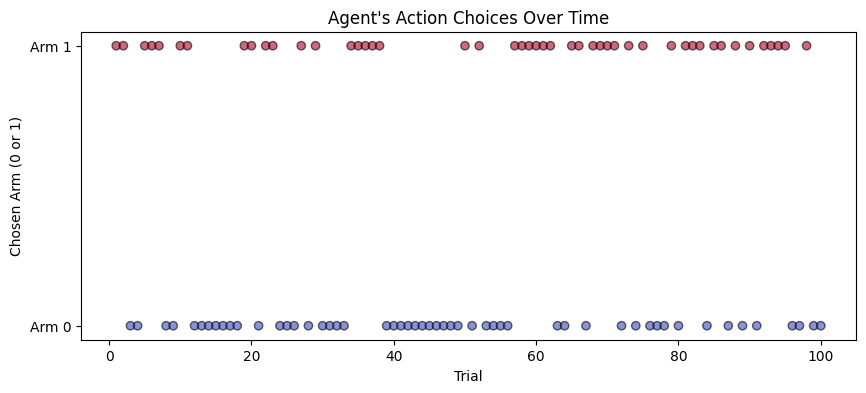

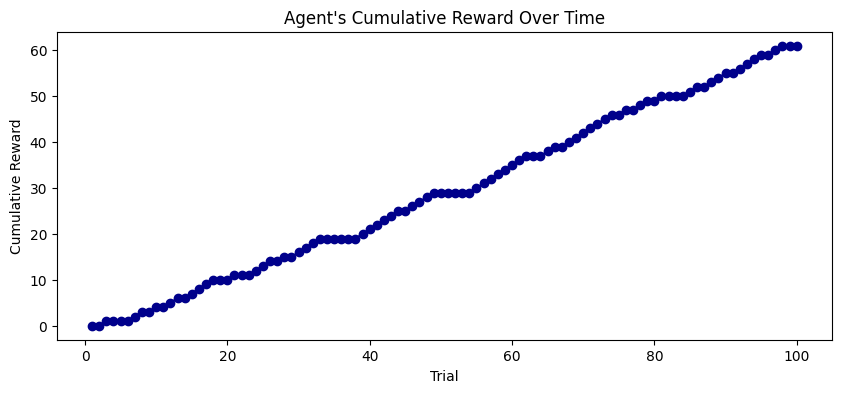

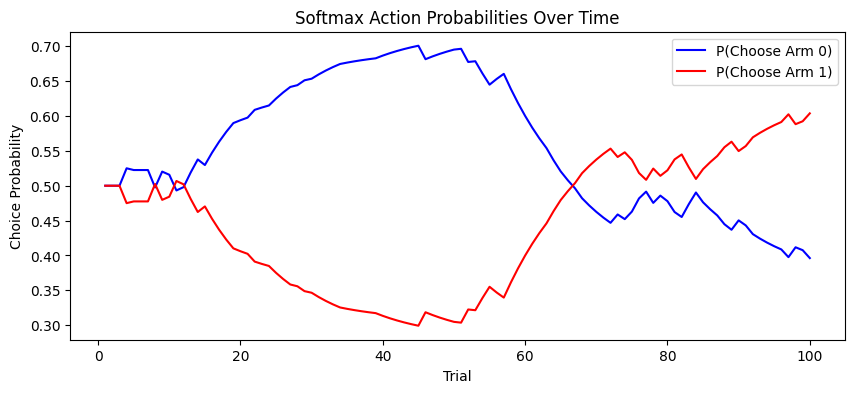

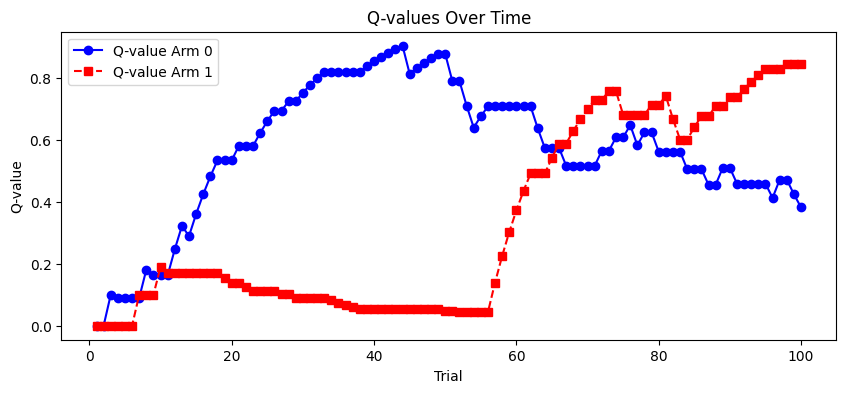

In [12]:
#Plots for Model-free agent
def plot_action_choices(data):
    """ Plots action choices over trials. """
    plt.figure(figsize=(10, 4))
    plt.scatter(data.index, data["action"], alpha=0.6, c=data["action"], cmap="coolwarm", edgecolors='k')
    plt.xlabel("Trial")
    plt.ylabel("Chosen Arm (0 or 1)")
    plt.title("Agent's Action Choices Over Time")
    plt.yticks([0, 1], labels=["Arm 0", "Arm 1"])
    plt.show()

def plot_cumulative_rewards(data):
    """ Plots cumulative rewards over trials. """
    data["cumulative_reward"] = data["reward"].cumsum()
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["cumulative_reward"], marker="o", linestyle="-", color="darkblue")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Reward")
    plt.title("Agent's Cumulative Reward Over Time")
    plt.show()

def plot_q_values(data):
    """ Plots Q-values for each arm over trials. """
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["Q0"], label="Q-value Arm 0", marker="o", linestyle="-", color="blue")
    plt.plot(data.index, data["Q1"], label="Q-value Arm 1", marker="s", linestyle="--", color="red")
    plt.xlabel("Trial")
    plt.ylabel("Q-value")
    plt.title("Q-values Over Time")
    plt.legend()
    plt.show()

def plot_action_probabilities(data):
    """ Plots softmax action probabilities over trials. """
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data["prob_0"], label="P(Choose Arm 0)", color="blue")
    plt.plot(data.index, data["prob_1"], label="P(Choose Arm 1)", color="red")
    plt.xlabel("Trial")
    plt.ylabel("Choice Probability")
    plt.title("Softmax Action Probabilities Over Time")
    plt.legend()
    plt.show()


plot_action_choices(data_model_free)
plot_cumulative_rewards(data_model_free)
plot_action_probabilities(data_model_free)
plot_q_values(data_model_free)

In [13]:
"""
Plotting Mean of Beta Distribution Over Time

"""
def plot_data(data,agent):
    plt.figure(figsize=(14, 5))
    # Plot for NoDecay agent
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(data["mean0"]) + 1), data["mean0"], linestyle='-', color='blue', label="Bandit 1")
    plt.plot(range(1, len(data["mean1"]) + 1), data["mean1"], linestyle='-', color='red', label="Bandit 2")

    plt.xlabel("Trial")
    plt.ylabel("Mean of Beta Distribution")
    plt.title(f"Beta Distribution Over Time for: {agent.get_name()}")
    plt.legend()
    plt.grid()

    # Show plot
    plt.show()

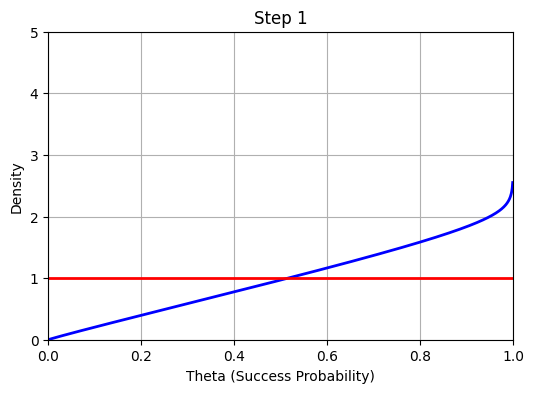

In [14]:
"""
Animation of Beta Distributions Over Time
WITH DECAY

"""

# X-axis values for Beta distribution
x = np.linspace(0, 1, 1000)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot([], [], 'b-', lw=2)
line2, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(0, 1)
ax.set_ylim(0, 5)
ax.set_xlabel("Theta (Success Probability)")
ax.set_ylabel("Density")
ax.set_title("Evolution of Beta Distribution with decay")
ax.grid()

# Update function for animation
def update(frame):
    # Compute Beta distribution
    y0 = beta.pdf(x, data_thompson_decay["alpha0"][frame+1], data_thompson_decay["beta0"][frame+1])
    y1 = beta.pdf(x, data_thompson_decay["alpha1"][frame+1], data_thompson_decay["beta1"][frame+1])

    # Update plot
    line1.set_data(x, y0)
    line1.set_color("blue")
    line2.set_data(x, y1)
    line2.set_color("red")
    ax.set_title(f"Step {frame+1}")
    return line1, line2

# Create animation
ani = animation.FuncAnimation(fig, update, frames=env.get_trial_number(), blit=False, interval=200)

HTML(ani.to_jshtml())

In [15]:
"""
Beta Distributions at different time steps

"""

def plot_overTime(data, agent):
    # X-axis values for Beta distribution
    x = np.linspace(0, 1, 1000)

    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
    fig.suptitle(f"Beta Distributions over time for: {agent.get_name()}")
    axes = axes.flatten()  # Flatten axes array for easy indexing


    for i, trial in enumerate(np.linspace(1, env.get_trial_number(), 6)):
        trial = int(np.round(trial))
        #get params
        alpha0 = round(data["alpha0"][trial],2)
        alpha1 = round(data["alpha1"][trial],2)
        beta0 = round(data["beta0"][trial],2)
        beta1 = round(data["beta1"][trial],2)

        # Compute Beta distribution
        y0 = beta.pdf(x, alpha0, beta0)
        y1 = beta.pdf(x, alpha1, beta1)

        # Plot the Beta distributions for arm 1 and arm 2 at time t
        axes[i].plot(x, y0, label=f"Arm 1: Beta({alpha0},{beta0})", color='blue')
        axes[i].plot(x, y1, label=f"Arm 2: Beta({alpha1},{beta1})", color='red')

        # Title and labels
        axes[i].set_title(f"Step {trial}: Beta Distributions")
        axes[i].set_xlabel("Theta (Success Probability)")
        axes[i].set_ylabel("Density")
        axes[i].legend()
        axes[i].grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [43]:
def run_simulation(n_runs = 50, n_trials = 100, random_seed = 42):
    """
    Example driver function to create many synthetic participants
    from each TS agent (with or without decay), each with random parameters.

    :param n_runs: how many participants to simulate PER agent class
    :param n_trials: number of trials in OneStepBanditEnv
    :param random_seed: seed for reproducibility
    :return: A single DataFrame with all simulation data
    """
    np.random.seed(random_seed)

    df_surrogated = []

    #simulate from TS with decay
    for run_idx in range(n_runs):
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        decay_agent = ThompsonSamplingAgentDecay(decay = np.random.uniform(0.9, 0.99))

        #run the simulation
        df_run = simulate_thompson(env, decay_agent)

        #add participant ID
        df_run["run_id"] = run_idx
        df_run["model_name"] = "TS_decay"
        df_run["true_decay"] = decay_agent.decay
        #append to list
        df_surrogated.append(df_run)

    #Simulate from Epsilon-Greedy with Decay
    """"for run_idx in range(n_runs):
        # Create a new environment for each participant
        env = OneStepBanditEnv(n_trials=n_trials)

        epsgreedy_agent = EpsilonGreedy(epsilon = np.random.uniform(0.001 , 0.4))

        # Run the simulation (you'll implement something like simulate_epsilon)
        df_run = simulate_epsilon(env, epsgreedy_agent)

        # Add identifying info
        df_run["run_id"] = run_idx
        df_run["model_name"] = "EGreedy"
        df_run["true_epsilon"] = epsgreedy_agent.epsilon

        df_surrogated.append(df_run)"""

    
    #simulate from model-free agent
    for run_idx in range(n_runs):
        #create a new env for each participant
        env = OneStepBanditEnv(n_trials= n_trials)

        #create a new agent for each participant
        model_free_agent = ModelFreeAgent(learning_rate = np.random.uniform(0.01, 0.9), inverse_temp = np.random.uniform(1, 5))

        #run the simulation
        df_run = simulate_model_free(env, model_free_agent)

        #add participant ID
        df_run["run_id"] = run_idx
        df_run["model_name"] = "ModelFree"
        df_run["true_learning_rate"] = model_free_agent.learning_rate
        df_run["true_inverse_temp"] = model_free_agent.inverse_temp
        #append to list
        df_surrogated.append(df_run)
    #combine all dataframes into one
    df_surrogated = pd.concat(df_surrogated)

    return df_surrogated

In [44]:
test_sim = run_simulation(10, 100, 42)
print(test_sim)

     action  reward    alpha0  alpha1     beta0  beta1  run_id model_name  \
1         0       0  0.933709     1.0  1.933709    1.0       0   TS_decay   
2         0       1  1.871812     1.0  1.805520    1.0       0   TS_decay   
3         0       1  2.747727     1.0  1.685830    1.0       0   TS_decay   
4         0       1  3.565576     1.0  1.574074    1.0       0   TS_decay   
5         0       1  4.329209     1.0  1.469726    1.0       0   TS_decay   
..      ...     ...       ...     ...       ...    ...     ...        ...   
96        1       1       NaN     NaN       NaN    NaN       9  ModelFree   
97        1       1       NaN     NaN       NaN    NaN       9  ModelFree   
98        1       0       NaN     NaN       NaN    NaN       9  ModelFree   
99        0       0       NaN     NaN       NaN    NaN       9  ModelFree   
100       1       1       NaN     NaN       NaN    NaN       9  ModelFree   

     true_decay    prob_0    prob_1        Q0        Q1  true_learning_rate

In [18]:
def compute_log_likelihood_model_free(data, learning_rate, inverse_temp):
    """
    Computes the log-likelihood of the observed choices under the Model-Free RL agent.

    Parameters:
        data: DataFrame containing trials (columns: 'action', 'reward')
        learning_rate: Learning rate parameter (alpha)
        inverse_temp: Inverse temperature parameter (beta)
    
    Returns:
        log-likelihood score
    """
    log_likelihood = 0
    Q = np.zeros(2)  # Initialize Q-values for both arms

    for _, row in data.iterrows():
        probs = softmax(Q, inverse_temp)
        action = int(row["action"])
        reward = row["reward"]
        
        log_likelihood += np.log(probs[action] + 1e-10)  # Avoid log(0)
        
        # Update Q-values using Rescorla-Wagner rule
        Q[action] += learning_rate * (reward - Q[action])

    return log_likelihood

In [19]:
def compute_log_likelihood_TS(agent, data, num_samples=1000):
    """
    Compute log-likelihood of observed choices by running the agent through trials.

    Args:
        agent: Thompson Sampling agent with `select_action()` and `update()` methods.
        data: DataFrame containing observed choices (`action`, `reward`).
        num_samples: Number of Monte Carlo samples for estimating choice probabilities.

    Returns:
        log-likelihood value.
    """
    log_likelihood = 0

    for _, row in data.iterrows():
        # Get observed action and reward
        observed_action = int(row['action'])
        reward = row['reward']

        #get current beta params from the agent
        bandit0_params, bandit1_params = agent.get_beta_parameters()
        a0, b0 = bandit0_params
        a1, b1 = bandit1_params

        #sample from beta distributions
        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0
        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1

        #compute choice probability
        probs = [0, 0]
        probs[0] = np.mean(samples_0 > samples_1)  # arm 0
        probs[1] = 1 - probs[0]  # arm 1

        # Compute log-likelihood for the observed action
        log_likelihood += np.log(probs[observed_action] + 1e-10)  # Add small constant to avoid log(0)

        # Update agent with the observed reward
        agent.update_values(observed_action, reward)

    return log_likelihood

In [20]:
# Create an environment
env = OneStepBanditEnv(n_trials=100)

agent_thompson = ThompsonSamplingAgentDecay(decay=0.95)
data_thompson = simulate_thompson(env, agent_thompson)

agent_model_free = ModelFreeAgent()
data_model_free = simulate_model_free(env, agent_model_free)
# Compute log-likelihood
ll = compute_log_likelihood_model_free(data_model_free, learning_rate= 0.4, inverse_temp=2)

print(ll)

-76.71777056328223


In [21]:
"""def compute_log_likelihood_EG(agent, data, num_samples=1000):
    
    Compute log-likelihood of observed choices by running the agent through trials.

    Args:
        agent: Thompson Sampling agent with `select_action()` and `update()` methods.
        data: DataFrame containing observed choices (`action`, `reward`).
        num_samples: Number of Monte Carlo samples for estimating choice probabilities.

    Returns:
        log-likelihood value.
    
    log_likelihood = 0

    for _, row in data.iterrows():
        # Get observed action and reward
        observed_action = row['action']
        reward = row['reward']

        #sample from beta distributionsr
        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0
        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1

        #compute choice probability
        probs = []
        probs[0] = np.mean(samples_0 > samples_1)  # arm 0
        probs[1] = 1 - prob_0  # arm 1

        # Compute log-likelihood for the observed action
        log_likelihood += np.log(probs[observed_action] + 1e-10)  # Add small constant to avoid log(0)

        # Update agent with the observed reward
        agent.update_values(observed_action, reward)

    return log_likelihood"""

"def compute_log_likelihood_EG(agent, data, num_samples=1000):\n    \n    Compute log-likelihood of observed choices by running the agent through trials.\n\n    Args:\n        agent: Thompson Sampling agent with `select_action()` and `update()` methods.\n        data: DataFrame containing observed choices (`action`, `reward`).\n        num_samples: Number of Monte Carlo samples for estimating choice probabilities.\n\n    Returns:\n        log-likelihood value.\n    \n    log_likelihood = 0\n\n    for _, row in data.iterrows():\n        # Get observed action and reward\n        observed_action = row['action']\n        reward = row['reward']\n\n        #sample from beta distributionsr\n        samples_0 = beta.rvs(a0, b0, size=num_samples) # monte carlo sampling for arm 0\n        samples_1 = beta.rvs(a1, b1, size=num_samples) # monte carlo sampling for arm 1\n\n        #compute choice probability\n        probs = []\n        probs[0] = np.mean(samples_0 > samples_1)  # arm 0\n        pr

In [34]:
def param_search_TS(data, decay_grid):
    """
    Searches over a 1D grid of decay values 
    to find the best-fitting parameter for ThompsonSamplingAgentDecay.

    :param data: DataFrame with columns ["action", "reward", ...]
    :param decay_grid: list or array of candidate decay values
    :return: (best_decay, best_LL)
    """
    best_LL = -np.inf
    best_decay = None

    for decay_candidate in decay_grid:
        # Create a fresh agent with that decay
        agent = ThompsonSamplingAgentDecay(decay=decay_candidate,
                                           alpha0_arm0=1.0, beta0_arm0=1.0,
                                           alpha0_arm1=1.0, beta0_arm1=1.0)
        # Compute log-likelihood
        LL = compute_log_likelihood_TS(agent, data)
        if LL > best_LL:
            best_LL = LL
            best_decay = decay_candidate

    return best_decay, best_LL

In [35]:
def param_recovery_TS(
    n_runs=20,
    decay_range=(0.9, 0.99),
    grid_size=10
):
    """
    1) Randomly sample "true" decay from a uniform range.
    2) Simulate data for each "subject."
    3) Search over a 1D grid to find the best-fitting decay.
    4) Return the results.

    :param n_runs: number of "subjects"
    :param decay_range: (min, max) for the "true" decay
    :param grid_size: how many points in the grid 
    :return: (true_decays, fitted_decays, best_LLs)
    """
    # Step 1: generate random "true" decays
    true_decays = np.random.uniform(decay_range[0], decay_range[1], n_runs)

    # Step 2: define a grid for searching
    decay_grid = np.linspace(decay_range[0], decay_range[1], grid_size)

    fitted_decays = []
    best_LLs = []

    for i in range(n_runs):
        # 1) Simulate data with a known "true" decay
        decay_true = true_decays[i]

        env = OneStepBanditEnv()
        agent = ThompsonSamplingAgentDecay(decay=decay_true,
                                           alpha0_arm0=1.0, beta0_arm0=1.0,
                                           alpha0_arm1=1.0, beta0_arm1=1.0)
        data = simulate_thompson(env, agent)

        # 2) Search for the best-fitting decay
        best_decay, best_LL = param_search_TS(data, decay_grid)
        fitted_decays.append(best_decay)
        best_LLs.append(best_LL)

    return true_decays, np.array(fitted_decays), np.array(best_LLs)

In [37]:
def param_search_model_free(data, alpha_grid, beta_grid):
    """
    Exhaustive 2D grid search for ModelFreeAgent.

    :param data: DataFrame of observed choices/rewards 
                 (as returned by simulate_model_free or from real participants)
    :param alpha_grid: list or array of possible alpha values
    :param beta_grid:  list or array of possible beta (inverse_temp) values
    :return: (best_alpha, best_beta, best_LL)
    """
    best_LL = -np.inf
    best_alpha = None
    best_beta = None

    # Loop over all combinations of alpha & beta
    for alpha in alpha_grid:
        for beta in beta_grid:
            # Create a fresh agent with those parameters
            agent = ModelFreeAgent(learning_rate=alpha, inverse_temp=beta)
            
            # Compute log-likelihood
            LL = compute_log_likelihood_model_free(
                data=data,
                learning_rate=alpha,
                inverse_temp=beta
            )
            # Alternatively: compute_log_likelihood_model_free(agent, data)
            #   But your function signature is currently 
            #   compute_log_likelihood_model_free(data, learning_rate, inverse_temp)

            # Keep track of the best result so far
            if LL > best_LL:
                best_LL = LL
                best_alpha = alpha
                best_beta = beta

    return best_alpha, best_beta, best_LL

In [38]:
def param_recovery_model_free(
    n_runs=20,
    alpha_range=(0.01, 0.9),   # Range for "true" alpha
    beta_range=(1.0, 5.0),     # Range for "true" beta
    grid_size=10
):
    """
    1) Randomly sample "true" alpha & beta from uniform ranges.
    2) Simulate data from each "subject."
    3) Perform a 2D grid search to find the best-fitting alpha & beta.
    4) Return the results for analysis.

    :param n_runs: how many "subjects" to simulate
    :param alpha_range: (min, max) for alpha
    :param beta_range:  (min, max) for beta
    :param grid_size:   how many points in each dimension of the grid
    :return: 
      - true_alphas:   array of length n_runs, the "true" alpha used
      - true_betas:    array of length n_runs, the "true" beta used
      - fitted_alphas: array of length n_runs, the best-fitting alpha recovered
      - fitted_betas:  array of length n_runs, the best-fitting beta recovered
      - best_LLs:      array of length n_runs, the best LL on that grid
    """
    # Create arrays of random "true" parameters
    true_alphas = np.random.uniform(alpha_range[0], alpha_range[1], n_runs)
    true_betas  = np.random.uniform(beta_range[0],  beta_range[1],  n_runs)

    # Prepare a grid for searching
    alpha_grid = np.linspace(alpha_range[0], alpha_range[1], grid_size)
    beta_grid  = np.linspace(beta_range[0],  beta_range[1],  grid_size)

    fitted_alphas = []
    fitted_betas  = []
    best_LLs      = []

    for i in range(n_runs):
        # For each "subject":
        alpha_true = true_alphas[i]
        beta_true  = true_betas[i]

        # 1) Simulate data from ModelFreeAgent
        env = OneStepBanditEnv()  
        agent = ModelFreeAgent(learning_rate=alpha_true, inverse_temp=beta_true)
        data = simulate_model_free(env, agent)
        # 2) Grid search to fit
        best_alpha, best_beta, best_LL = param_search_model_free(data, alpha_grid, beta_grid)

        fitted_alphas.append(best_alpha)
        fitted_betas.append(best_beta)
        best_LLs.append(best_LL)

    return true_alphas, true_betas, np.array(fitted_alphas), np.array(fitted_betas), np.array(best_LLs)

In [39]:
#visualize model-free param recovery
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

def plot_param_recovery_model_free(true_alphas, true_betas, fitted_alphas, fitted_betas):
    # We can do two subplots: one for alpha, one for beta
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 1) alpha
    ax = axes[0]
    ax.scatter(true_alphas, fitted_alphas)
    # identity line
    min_val = min(true_alphas.min(), fitted_alphas.min())
    max_val = max(true_alphas.max(), fitted_alphas.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
    ax.set_xlabel('True alpha')
    ax.set_ylabel('Fitted alpha')
    corr_alpha, p_alpha = pearsonr(true_alphas, fitted_alphas)
    ax.set_title(f'Alpha Recovery (r={corr_alpha:.3f}, p={p_alpha:.3g})')

    # 2) beta
    ax = axes[1]
    ax.scatter(true_betas, fitted_betas)
    # identity line
    min_val = min(true_betas.min(), fitted_betas.min())
    max_val = max(true_betas.max(), fitted_betas.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
    ax.set_xlabel('True beta')
    ax.set_ylabel('Fitted beta')
    corr_beta, p_beta = pearsonr(true_betas, fitted_betas)
    ax.set_title(f'Beta Recovery (r={corr_beta:.3f}, p={p_beta:.3g})')

    plt.tight_layout()
    plt.show()

In [40]:
#visualize param recovery for TS
def plot_param_recovery_TS(true_decays, fitted_decays):
    plt.figure(figsize=(6,6))
    plt.scatter(true_decays, fitted_decays)
    min_val = min(true_decays.min(), fitted_decays.min())
    max_val = max(true_decays.max(), fitted_decays.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)
    plt.xlabel('True Decay')
    plt.ylabel('Fitted Decay')

    corr, p_value = pearsonr(true_decays, fitted_decays)
    plt.title(f'Decay Recovery (r={corr:.3f}, p={p_value:.3g})')
    plt.show()

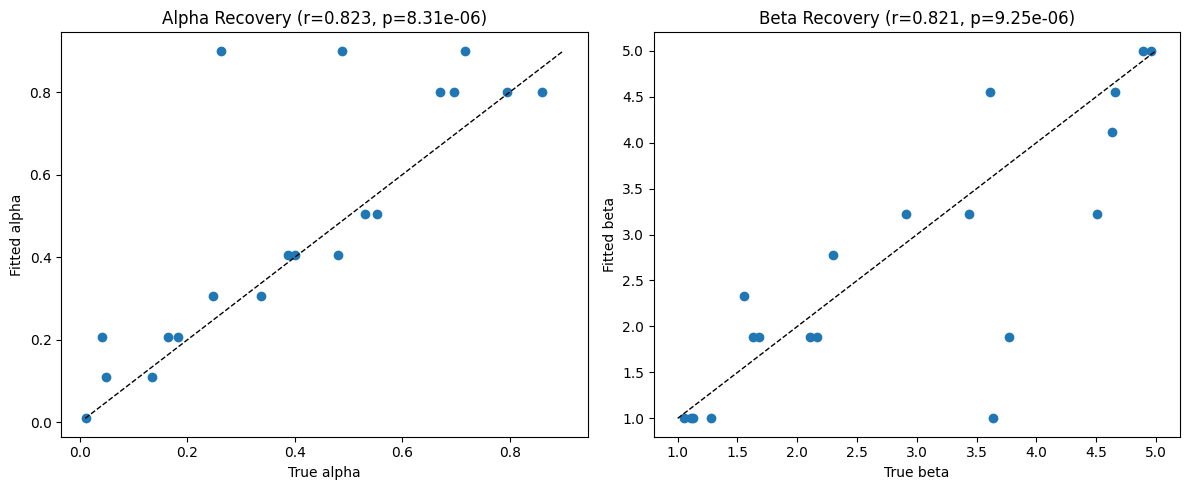

In [41]:
# Recover from 20 "subjects", alpha in [0.01..0.9], beta in [1..5]
true_alphas, true_betas, fitted_alphas, fitted_betas, best_LLs = param_recovery_model_free(
    n_runs=20,
    alpha_range=(0.01, 0.9),
    beta_range=(1.0, 5.0),
    grid_size=10
)
plot_param_recovery_model_free(true_alphas, true_betas, fitted_alphas, fitted_betas)

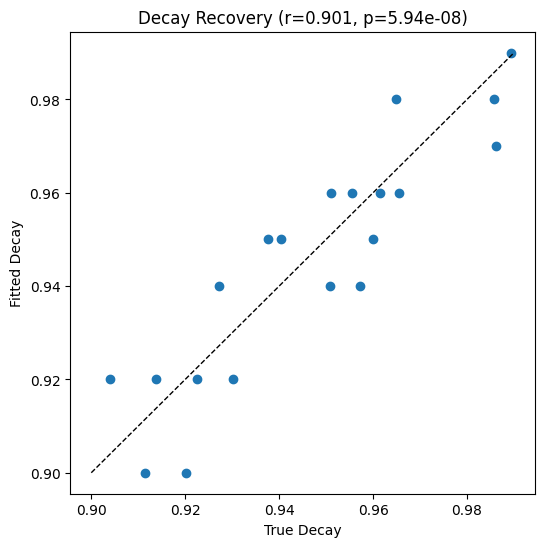

In [42]:
# 20 subjects, decay in [0.9..0.99], 10 grid points
true_decays, fitted_decays, best_LLs = param_recovery_TS(
    n_runs=20, 
    decay_range=(0.9, 0.99), 
    grid_size=10
)
plot_param_recovery_TS(true_decays, fitted_decays)

In [46]:
#comparing cumulative rewards for both models
def compare_cumulative_reward(n_runs=50, n_trials=100, random_seed=42):
    
    np.random.seed(random_seed)

    
    df_all = run_simulation(n_runs=n_runs, n_trials=n_trials, random_seed=random_seed)
    
    df_TS = df_all[df_all["model_name"] == "TS_decay"].copy()
    df_MF = df_all[df_all["model_name"] == "ModelFree"].copy()

    
    df_TS["cumulative_reward"] = df_TS.groupby("run_id")["reward"].cumsum()
    df_MF["cumulative_reward"] = df_MF.groupby("run_id")["reward"].cumsum()

    #compute the mean across runs for each trial
    # "env.get_trial_number()" was stored as the index so rename that to "trial"
    df_TS = df_TS.reset_index().rename(columns={"index": "trial"})
    df_MF = df_MF.reset_index().rename(columns={"index": "trial"})

    # group by trial, then average "cumulative_reward"
    df_TS_mean = df_TS.groupby("trial")["cumulative_reward"].mean()
    df_MF_mean = df_MF.groupby("trial")["cumulative_reward"].mean()

    
    plt.figure(figsize=(8, 6))
    plt.plot(df_TS_mean.index, df_TS_mean.values, label="TS (decay)")
    plt.plot(df_MF_mean.index, df_MF_mean.values, label="Model-Free")
    plt.title("Cumulative Reward Comparison")
    plt.xlabel("Trial")
    plt.ylabel("Cumulative Reward (mean over runs)")
    plt.legend()
    plt.show()

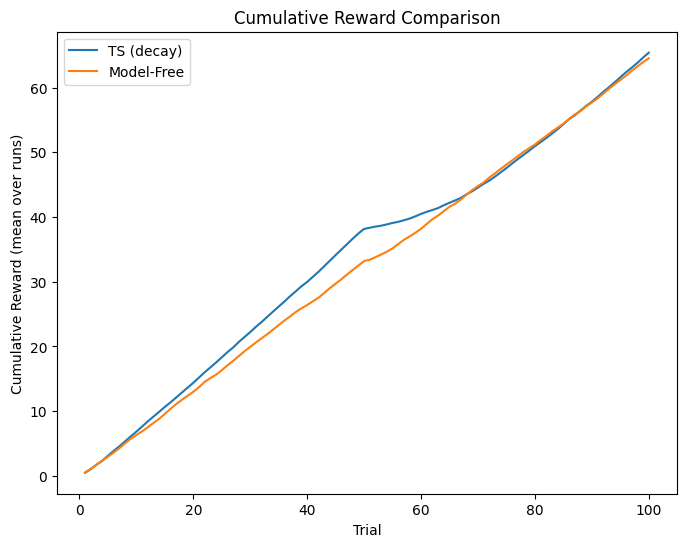

In [50]:
#use of compare_cumulative_reward()

compare_cumulative_reward(n_runs=50, n_trials=100, random_seed=42)

In [47]:
#exploration comparison 
def compute_exploration_rate_model_free(env, agent, n_trials=100):
    """
    Runs a single simulation with a model-free agent,
    then calculates how often the chosen action wasn't the greedy Q-value.
    """
    env.reset()
    agent.Q_table = np.zeros(2)

    n_explores = 0
    for t in range(n_trials):
        # Softmax probability distribution:
        probs = softmax(agent.Q_table, agent.inverse_temp)
        # Pick action
        action = np.random.choice([0,1], p=probs)
        # The greedy action is argmax(Q_table)
        greedy_action = np.argmax(agent.Q_table)
        if action != greedy_action:
            n_explores += 1
        
        # Step in env, update Q
        reward, done = env.step(action)
        agent.update_values(action, reward)
        if done:
            break
    
    return n_explores / n_trials

def compute_exploration_rate_TS(env, agent, n_trials=100):
    """
    ThompsonSampling. 
    We'll define the "greedy" action as the arm with the higher posterior mean:
        mean0 = alpha0 / (alpha0 + beta0), etc.
    Then check if the chosen action equals that greedy action or not.
    """
    env.reset()
    agent.__init__(decay=agent.decay,  # re-initialize
                   alpha0_arm0=1.0, beta0_arm0=1.0,
                   alpha0_arm1=1.0, beta0_arm1=1.0)

    n_explores = 0
    for t in range(n_trials):
        # "Posterior mean" for each arm
        bandit0, bandit1 = agent.get_beta_parameters()
        mean0 = bandit0[0] / (bandit0[0] + bandit0[1]) 
        mean1 = bandit1[0] / (bandit1[0] + bandit1[1])
        greedy_action = 0 if mean0 > mean1 else 1
        
        # Thompson-sample action
        action = agent.policy()  # draws from Beta, picks best sample
        if action != greedy_action:
            n_explores += 1

        reward, done = env.step(action)
        agent.update_values(action, reward)
        if done:
            break

    return n_explores / n_trials

def compare_exploration(n_runs=50, n_trials=100):
    """
    Runs multiple simulations for each model and compares average exploration rate.
    """
    exploration_rates_MF = []
    exploration_rates_TS = []

    for _ in range(n_runs):
        # randomize model-free agent parameters if you like
        mf_agent = ModelFreeAgent(learning_rate=0.3, inverse_temp=2.0)
        env = OneStepBanditEnv(n_trials=n_trials)
        rate_mf = compute_exploration_rate_model_free(env, mf_agent, n_trials=n_trials)
        exploration_rates_MF.append(rate_mf)

        # randomize TS agent param if you like
        ts_agent = ThompsonSamplingAgentDecay(decay=0.95)
        env2 = OneStepBanditEnv(n_trials=n_trials)
        rate_ts = compute_exploration_rate_TS(env2, ts_agent, n_trials=n_trials)
        exploration_rates_TS.append(rate_ts)

    print(f"Model-Free exploration rate (mean): {np.mean(exploration_rates_MF):.3f}")
    print(f"TS exploration rate (mean):         {np.mean(exploration_rates_TS):.3f}")

In [52]:
# Compare exploration rates
compare_exploration(n_runs=50, n_trials=100)


Model-Free exploration rate (mean): 0.268
TS exploration rate (mean):         0.106


In [48]:
#compare the adaptability of the models
def compute_learning_curve(env, agent, n_trials=100, reversal_trial=50):
    """
    Returns a list/array of 'optimal_choice' over trials, 1 if picks the bandit
    that actually has the higher reward prob, else 0.
    """
    # We'll assume the env is set with p_bandit0=0.8, p_bandit1=0.2, reversal_trial=50
    # so 'optimal' is bandit0 until trial=50, then bandit1 after that
    env.reset()
    optimal_choices = []
    
    for t in range(n_trials):
        # Decide which bandit is truly better at this trial
        # If we've not yet reversed, bandit0 is best; otherwise bandit1 is best.
        true_optimal = 0 if (t < reversal_trial) else 1

        # Agent picks action
        if isinstance(agent, ModelFreeAgent):
            # softmax
            probs = softmax(agent.Q_table, agent.inverse_temp)
            action = np.random.choice([0,1], p=probs)
        else:
            # TS agent
            action = agent.policy()

        # Check if it was the correct/optimal bandit
        optimal_choices.append(1 if action == true_optimal else 0)

        # Step env, update agent
        reward, done = env.step(action)
        agent.update_values(action, reward)
        if done:
            break
    
    return np.array(optimal_choices)

def compare_adaptation(n_runs=50, n_trials=100, reversal_trial=50, random_seed=42):
    """
    1) Runs multiple simulations with ModelFree and TS agents,
    2) Tracks proportion of optimal choices over time,
    3) Plots average performance across runs (learning curve).
    """
    np.random.seed(random_seed)

    # We'll store an array of shape (n_runs, n_trials) for each model
    MF_optimal_choices = []
    TS_optimal_choices = []

    for _ in range(n_runs):
        # Make model-free
        mf_agent = ModelFreeAgent(learning_rate=0.3, inverse_temp=2.0)
        env_mf = OneStepBanditEnv(n_trials=n_trials, reversal_trial=reversal_trial)
        mf_opt_choices = compute_learning_curve(env_mf, mf_agent, n_trials, reversal_trial)
        MF_optimal_choices.append(mf_opt_choices)

        # Make TS
        ts_agent = ThompsonSamplingAgentDecay(decay=0.95)
        env_ts = OneStepBanditEnv(n_trials=n_trials, reversal_trial=reversal_trial)
        ts_opt_choices = compute_learning_curve(env_ts, ts_agent, n_trials, reversal_trial)
        TS_optimal_choices.append(ts_opt_choices)

    MF_optimal_choices = np.array(MF_optimal_choices)  # shape (n_runs, n_trials)
    TS_optimal_choices = np.array(TS_optimal_choices)

    # average across runs
    MF_mean = MF_optimal_choices.mean(axis=0)  # shape (n_trials,)
    TS_mean = TS_optimal_choices.mean(axis=0)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(MF_mean, label="Model-Free")
    plt.plot(TS_mean, label="Thompson Sampling")
    plt.axvline(x=reversal_trial, color='gray', linestyle='--', label="Reversal Point")
    plt.title("Adaptation to Reversal: Proportion of Optimal Choices")
    plt.xlabel("Trial")
    plt.ylabel("Optimal Choice Probability")
    plt.legend()
    plt.show()


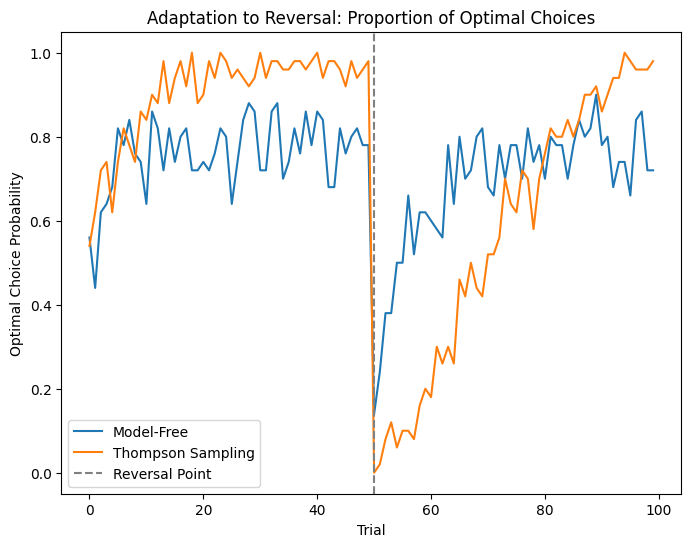

In [53]:
# Compare how quickly Model-Free and TS adapt after the reversal point
compare_adaptation(n_runs=50, n_trials=100, reversal_trial=50, random_seed=42)

In [49]:
#BIC comparison
def calculate_bic(num_params, num_data_points, ll):
    
    bic = num_params * np.log(num_data_points) - 2 * ll
    return  bic


In [51]:
#use BIC
env = OneStepBanditEnv(n_trials=100, p_bandit0=0.8, p_bandit1=0.2, reversal_trial=50)
mf_agent = ModelFreeAgent(learning_rate=0.3, inverse_temp=2.0)
df_data_mf = simulate_model_free(env, mf_agent)
ll_mf = compute_log_likelihood_model_free(data=df_data_mf, learning_rate=0.3, inverse_temp=2.0)
bic_mf = calculate_bic(num_params=2, num_data_points=len(df_data_mf), ll=ll_mf)
print(f"Model-Free BIC: {bic_mf:.2f}")


env.reset()
ts_agent = ThompsonSamplingAgentDecay(decay=0.95)
df_data_ts = simulate_thompson(env, ts_agent)

ll_ts = compute_log_likelihood_TS(ts_agent, df_data_ts)

bic_ts = calculate_bic(num_params=1, num_data_points=len(df_data_ts), ll=ll_ts)
print(f"TS BIC: {bic_ts:.2f}")


Model-Free BIC: 106.16
TS BIC: 188.05
